<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

## Подготовка

In [1]:
import pandas as pd
import numpy as np 
import re
import nltk
from nltk import corpus
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
import transformers

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier


from sklearn.model_selection import cross_val_score
import time
import warnings
warnings.filterwarnings('ignore')

from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer 

from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet

from nltk.stem import WordNetLemmatizer 

import matplotlib.pyplot as plt


from sklearn.utils import shuffle
from sklearn.metrics import f1_score 
from tqdm import tqdm_notebook as tqdm
from nltk.corpus import stopwords as nltk_stopwords
import spacy
nlp = spacy.load("en_core_web_sm")
nltk.download('stopwords') 
stop_words = set(nltk_stopwords.words('english')) 

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [4]:
data = data.drop(['Unnamed: 0'], axis=1)


In [5]:
print(data.isnull().sum())

print(data[data.duplicated()])

text     0
toxic    0
dtype: int64
Empty DataFrame
Columns: [text, toxic]
Index: []


In [6]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [8]:
corpus = list(data['text'])

In [9]:
lemmatizer = WordNetLemmatizer()
def clear_text(text):
    clean=re.sub(r"[^'a-zA-Z ]", ' ', text) 
    lemmatized_output=" ".join(clean.split())
    return lemmatized_output

In [10]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [23]:
%%time
def lemma_func(text_1):
    lemmatized_output=[]
    for a in nltk.word_tokenize(text_1):
        clean=lemmatizer.lemmatize(a, get_wordnet_pos(a))
        lemmatized_output.append(clean)
    return ' '.join(lemmatized_output) 

lemm=[]
for i in tqdm(range(len(corpus))):
    
    lemm.append(lemma_func(clear_text(corpus[i])))
data['lemmatize']=pd.Series(lemm, index=data.index)

  0%|          | 0/159292 [00:00<?, ?it/s]

CPU times: user 19min 17s, sys: 1min 58s, total: 21min 16s
Wall time: 21min 49s


In [24]:
data.head()

,text,toxic,lemmatize
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,D'aww He match this background colour I 'm see...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I 'm really not try to edit war It 's ...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I ca n't make any real suggestion on impr...
4,"You, sir, are my hero. Any chance you remember...",0,You sir be my hero Any chance you remember wha...


Проверили, все хорошо. Теперь разделим датасет на целевые признаки и данные. И разделим на тренировочные и тестовые выборки.

In [25]:
features = data.drop(['toxic'], axis = 1)
target = data['toxic']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345, shuffle=True,stratify=target)



In [26]:
print(features_train.shape)
print(features_test.shape)

print(target_train.shape)
print(target_test.shape)

(119469, 2)
(39823, 2)
(119469,)
(39823,)


Теперь посмотрим на баланс распределения классов по выборкам.

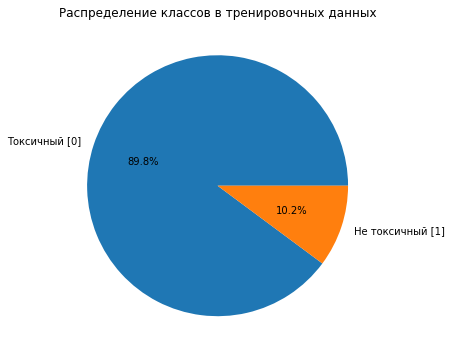

In [27]:
target_train.value_counts(normalize=True).plot(kind='pie',figsize=[6,6], legend=False, autopct='%1.1f%%',labels=['Токсичный [0]','Не токсичный [1]'])
plt.title('Распределение классов в тренировочных данных')
plt.ylabel('')
plt.show()

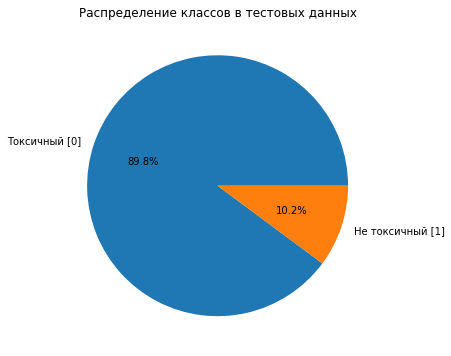

In [28]:
target_test.value_counts(normalize=True).plot(kind='pie',figsize=[6,6], legend=False, autopct='%1.1f%%',labels=['Токсичный [0]','Не токсичный [1]'])
plt.title('Распределение классов в тестовых данных')
plt.ylabel('')
plt.show()

Данные готовы к обучению

## Обучение

In [29]:
features_train.head()

,text,lemmatize
129315,Accusation of vandalism? \n\nWhat was the caus...,Accusation of vandalism What be the cause and ...
8868,Shorter Oxford English Dictionary\nArrived tod...,Shorter Oxford English Dictionary Arrived toda...
75827,"Kim, stop! You are not helping here!!! This is...",Kim stop You be not help here This be fan the ...
137701,My blocking by user Jayron32 \n\nI believe t...,My block by user Jayron I believe that this bl...
28407,Simple quote\nDon't you think this essentially...,Simple quote Do n't you think this essentially...


In [30]:
target_train.head()

129315    0
8868      0
75827     0
137701    0
28407     0
Name: toxic, dtype: int64

0.77  при C=10, class_weight='balanced', random_state=12345

0,76 при learning_rate=0.25, max_depth=-1, n_estimators=200, random_state = 12345

<div class="alert alert-info">
<font size="2"><b> считает более двух часов выписала результаты и выключила </b></font>

In [31]:
vectorize = TfidfVectorizer(ngram_range=(1,3),
               min_df=3, max_df=0.9, use_idf=1,
               smooth_idf=1, sublinear_tf=1, stop_words=stop_words)
features_train = vectorize.fit_transform(features_train['lemmatize'])
features_test = vectorize.transform(features_test['lemmatize'])


In [38]:
log_m = LogisticRegression(C=10, class_weight='balanced', random_state=12345)
log_m.fit(features_train, target_train)


LogisticRegression(C=10, class_weight='balanced', random_state=12345)

Проверим значение метрики F1 лучшей модели LogisticRegression.

## Выводы

In [36]:
log_test_pred = log_m.predict(features_test)
f1_log_score = f1_score(target_test,log_test_pred).round(2)

print('F1:', f1_log_score)

F1: 0.78


Лучшее значение метрики F1 на тестовой выборке 0,78 у модели LogisticRegression.

# Вывод: 
       В данном проекте нам требовалось помочь интернет-магазину "Викишоп" в запуске его нового сервиса. Необходим инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.
       
       Нам было необходимо  обучить модель разделять на позитивные и негативные комментарии. Данные метрики качества F1 должны быть не меньше 0,75.
       
       Мы загрузили необходимыедля выполения проекта библиотеки, загрузили файл, изучили и проанализировали данные. Пр неккоректной загрузке файла появился новый столбец. Мы его убрали.
 
      Изучили распределение классов по группам
      Провели лемматизацию данных
      Разделили датасет на целевой признак и данные
      Разбили выборки на тренировочную и тестовую
      Обучили две модели LogisticRegression и LGBMClassifier, значение метрики на тренировочной выборке лучшее на модели LogisticRegression. 
      Использовали технологию TF-IDF для обработки наших данных, а так же отфильтровали содержимое при помощи библиотеки nltk.
      Обучили наши модели с учетом обработки данных и проверили качество метрики на тестовой выборке.
      Лучшее значение метрики F1 на тестовой выборке 0.78, у модели LogisticRegression.
      Магазину "ВИКИШОП" можем рекомендовать использование в своей работе нашей модели.
      